# Basics of mobile robotics project - The Thytanic Navigation (2024)

## 1. Introduction & Context

| **Contributors**         | **Sciper**  | **Role**             | **Studies**                                                             |
|---------------------------|-------------|-----------------------|---------------------------------------------------------------------------|
| **Alessio Desogus**       | 301705      | Local Navigation      | Bachelor and Master in Mechanical Engineering.                            |
|   **Antoine Bachmann**    |  336641     | Global navigation      | Bachelor and Master in Computer Science                                   |
|**Ramon Heeb**             |   396213    | Vision                | Bachelor in Computer Science, Master in Robotics                           |
|                           |             |                       |                                                                           |

Date of deliverable: 05.12.2024  

Our main sources were the exercise sessions of the course and ....

### Project Description




### Environment



## 2. Initialization

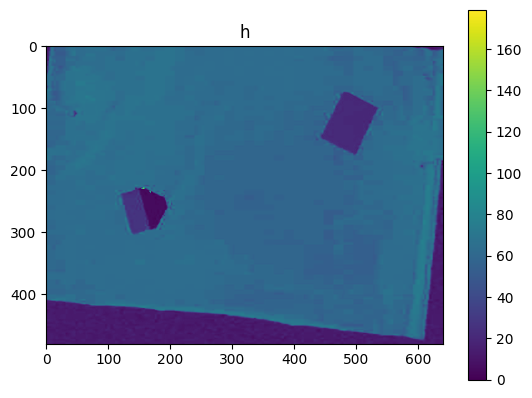

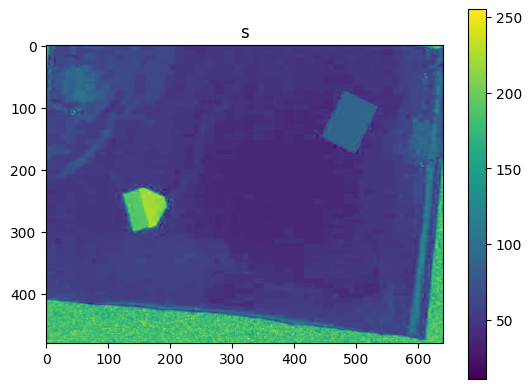

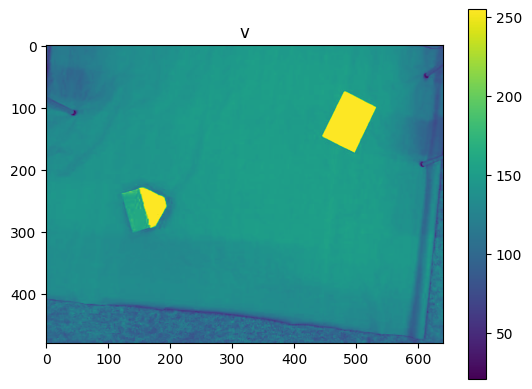

In [1]:
from local_navigation_and_control_all import ThytanicController, ThytanicState
from vision import get_current_state, init_cam
from global_navigation import downsamplingprep, downsampling, pathfinder
from kalman_filtering_all import kalman_filter
import numpy as np, matplotlib.pyplot as plt

In [7]:
# Initialize the ThytanicController
thytanic = ThytanicController()

## 3. Vision

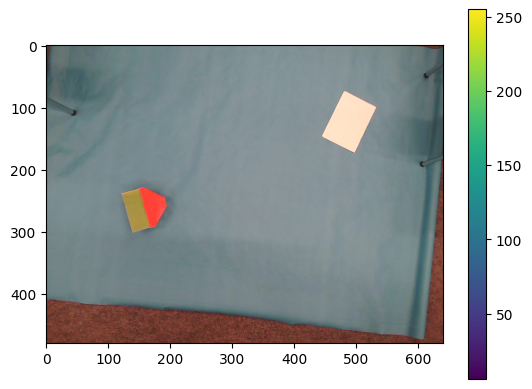

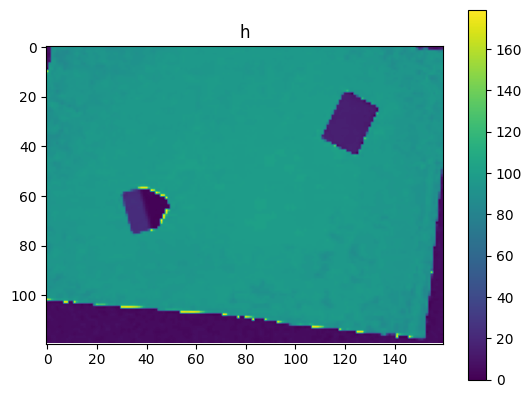

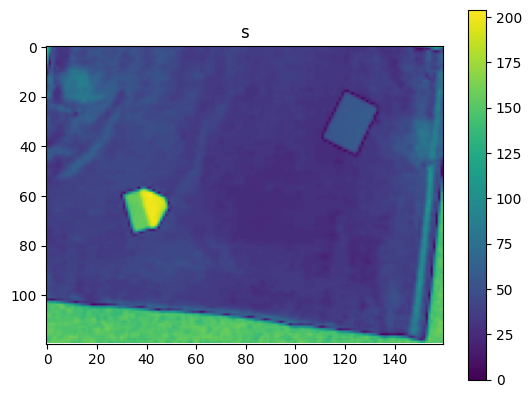

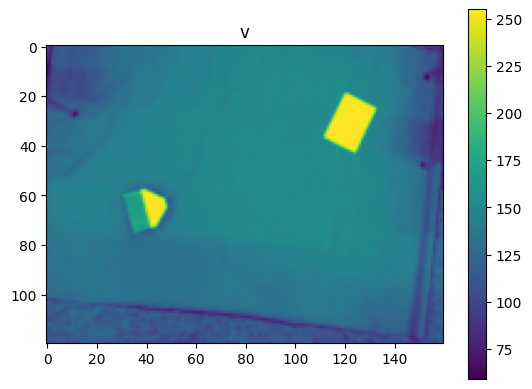

position of the thymio
[np.float64(65.71612903225807), np.float64(39.00645161290323)]
orientation
104.2889247985997


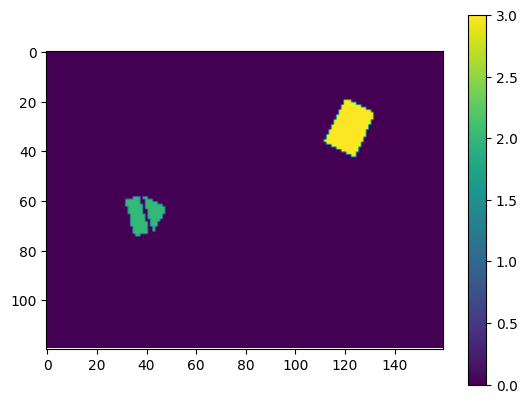

In [2]:
#turn the image into a 4-channel map
cam = init_cam()
img, _, _ = get_current_state(
    cam=cam,
    obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
    target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
    th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
    th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],
)

## 4. Global Navigation


[]

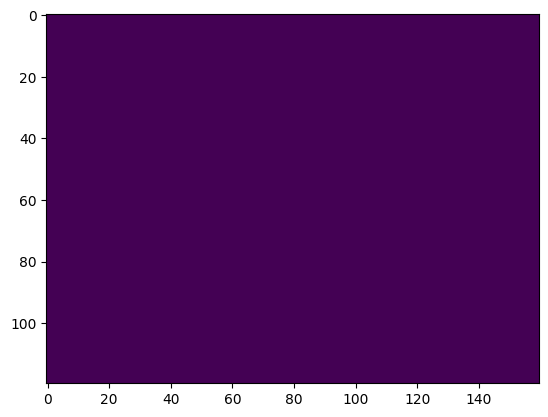

In [3]:
endsize = [120, 160]

#this line generates the original enposition, thymio position, and the obstacle channel
thymiopos, endpos, obstacleimage = downsamplingprep(img, endsize, 1, 1)

#this line turns obstacleimage into its downsampled version with enlarged obstacles
preppedimage = downsampling(obstacleimage, endsize, 5, 0.2)


plt.imshow(preppedimage)
plt.plot()

[]

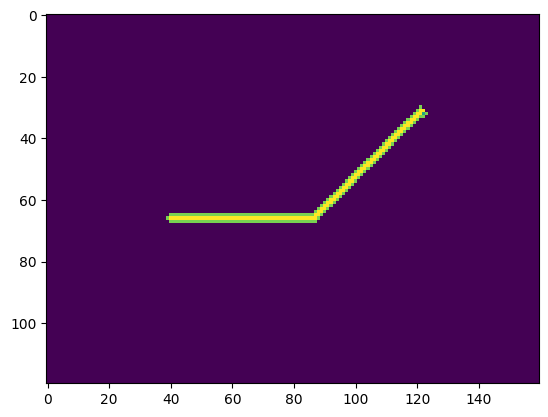

In [4]:
path, exploredpoints, unexploredpoints = pathfinder(thymiopos, endpos, preppedimage)

testimage = preppedimage.copy()

for k in path:
    testimage[k[0], k[1]] += 2
    
for k in exploredpoints:
    testimage[k[0], k[1]] += 3

for k in unexploredpoints:
    testimage[k[0], k[1]] += 4


plt.imshow(testimage)
plt.plot()

## 5. Kalman Filter

## 6. Local Navigation

![Local Navigation Algorithm](img/local_nav.png)

Connecting to Thytanic...
Connection established!


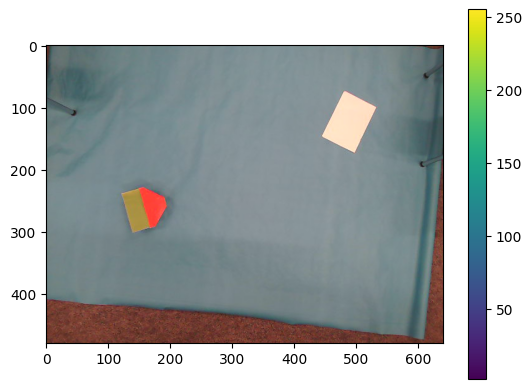

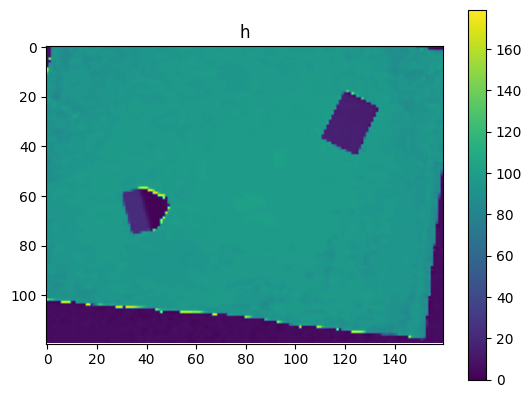

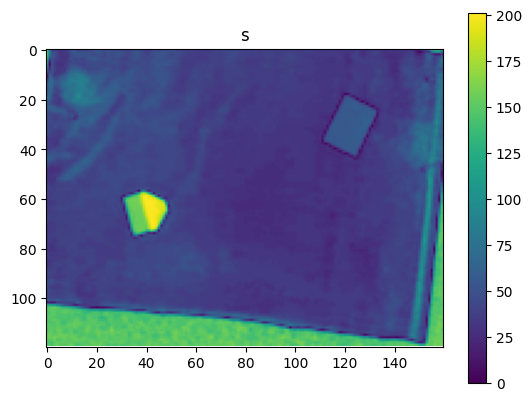

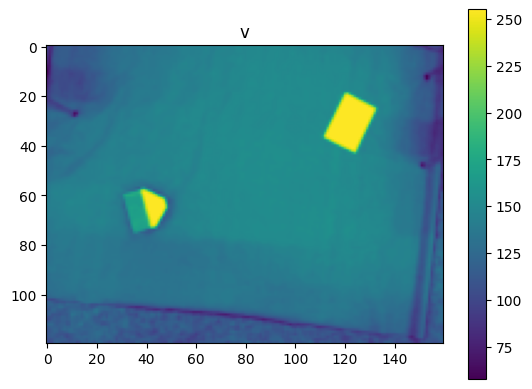

position of the thymio
[np.float64(65.78205128205128), np.float64(38.92948717948718)]
orientation
104.7479348052729


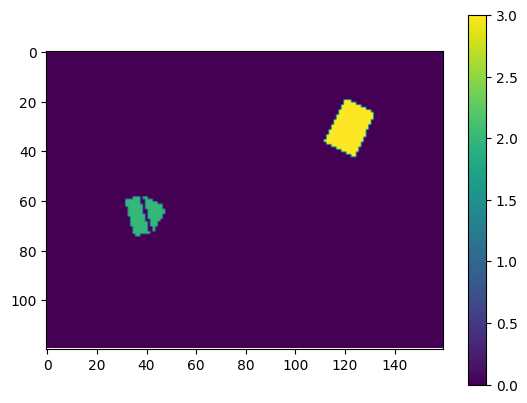

Thytanic state set to GLOBAL_MOVEMENT.
accelerometer: Node array variable acc[3]
goal [50 66]
x 38.92948717948718 y 65.78205128205128 theta 0.0
goal index 0
delta_x 11.070512820512818 delta_y 0.2179487179487154
alpha -0.019684776102239395
v 200 omega -0.2755868654313515
accelerometer: Node array variable acc[3]
goal [50 66]
x 38.92948717948718 y 65.78205128205128 theta 0.0
goal index 0
delta_x 11.070512820512818 delta_y 0.2179487179487154
alpha -0.019684776102239395
v 200 omega -0.2755868654313515
accelerometer: Node array variable acc[3]
goal [50 66]
x 38.92948717948718 y 65.78205128205128 theta 0.0
goal index 0
delta_x 11.070512820512818 delta_y 0.2179487179487154
alpha -0.019684776102239395
v 200 omega -0.2755868654313515
accelerometer: Node array variable acc[3]
goal [50 66]
x 39.84618415023222 y 65.78205128205128 theta 0.0068242162640142524
goal index 0
delta_x 10.153815849767781 delta_y 0.2179487179487154
alpha -0.02828563119504911
v 200 omega -0.39599883673068753
accelerometer: 

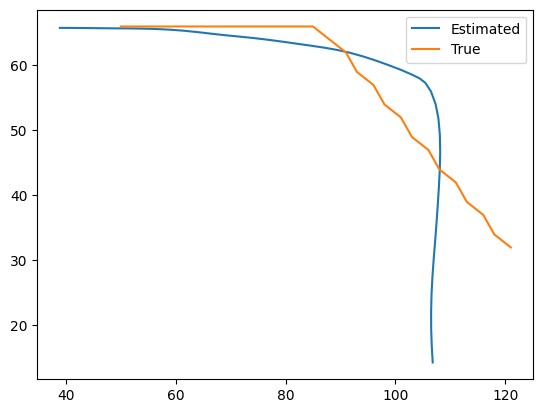

In [8]:
# Main script to establish connection and start movement
try:
    print("Connecting to Thytanic...")
    thytanic.establish_connection()
    print("Connection established!")

    _, thymiopos, initital_angle = get_current_state(    cam=cam,
    obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
    target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
    th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
    th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],)
    # Set the robot to GLOBAL_MOVEMENT state
    thytanic.x_est = np.array([thymiopos[1], 0, thymiopos[0], 0,0,0]) #position, velocity (x,y,angle)
    thytanic.P_est = np.eye(6) # TO TUNE
    thytanic.goal_idx = 0
    thytanic.robot_state = ThytanicState.GLOBAL_MOVEMENT
    #thytanic.set_wheel_speed(100, 100)
    print("Thytanic state set to GLOBAL_MOVEMENT.")
    x_estimated = []
    ########################
    
    path = path[::5]
    path = path[2:]
    path = np.array([[p[1], p[0]] for p in path])
    ##########################
    # Start the robot movement loop
    while True:
        thytanic.read_accelerometer()
        # apply kalman filter and get the estimated positions thytanic.x_est
        kalman_filter(thytanic,None) #no camera 
        x_estimated.append(thytanic.x_est)
        #print("x_est", thytanic.x_est)
        thytanic.goal = path[thytanic.goal_idx] # get the (x,y) coordinates of the goal point
        print("goal", thytanic.goal)
        #print("goal_idx", thytanic.goal_idx)
        thytanic.update_robot_state()

        # Print the proximity sensor values
        sensor_values = thytanic.read_proximity_sensors()
        #print("Proximity sensor readings -- threshold of 2000 for detection:", sensor_values)
        
        if thytanic.goal_idx >= len(path):
            thytanic.robot_state = ThytanicState.STOP
            thytanic.update_robot_state()
            print("Goal reached!")
            break 

except KeyboardInterrupt:
    # Handle interruption and stop the robot safely
    print("\nStopping the Thytanic...")
    thytanic.disconnect()
    print("Thytanic stopped and disconnected.")

finally:
    print("Session ended.")
    plt.figure()
    plt.plot(np.array(x_estimated)[:,0], np.array(x_estimated)[:,2], label='Estimated')
    plt.plot(path[:,0], path[:,1], label='True')
    # Plot the path
    plt.legend()
    thytanic.disconnect()

## 7. Main Loop

## 8. Stopping

## 9. Conclusion